<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
from google.colab import files, drive
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
drive.mount('/content/drive')

Mounted at /content/drive


### Make dictionary for details about conflicts

In [16]:
df_conflicts = pd.read_csv('/content/drive/My Drive/Data_sci/icb1v15.csv')
df_actors = pd.read_csv('/content/drive/My Drive/Data_sci/icb2v15.csv')
country_codes = pd.read_csv('/content/drive/My Drive/Data_sci/country_codes_15-04.csv')

crisis_details = {}

for index, row in df_conflicts.iterrows():
    crisis_number = row['crisno']  # Crisis number
    crisis_name = row['crisname']  # Crisis name
    start_year = row['yrtrig']  # Start year
    end_year = row['yrterm']  # End year

    crisis_details[crisis_number] = {'crisis_name': crisis_name,
                                      'start_year': start_year,
                                      'end_year': end_year,
                                      'actors': set()}

for index, row in df_actors.iterrows():
    crisis_number = row['crisno']  # Crisis number
    r = row['actor']
    idx = np.where(country_codes == row['actor'])[0] # Actor
    actor = country_codes.iloc[idx[0],0]

    if crisis_number in crisis_details:
        crisis_details[crisis_number]['actors'].add(actor)


### Make matrix for conflicts (i) and actors (j), for if a conflict has been started

In [28]:
actors = set()
for _, details in crisis_details.items():
    actors.update(details['actors'])

matrix_data = []
for _, details in crisis_details.items():
    crisis_year = details['start_year']
    crisis_actors = details['actors']
    row_data = {'Year': crisis_year}
    for actor in actors:
        row_data[actor] = 1 if actor in crisis_actors else 0
    matrix_data.append(row_data)

actor_crisis_matrix = pd.DataFrame(matrix_data)

columns = actor_crisis_matrix.columns.tolist()
columns.remove('Year')
columns = ['Year'] + columns

actor_crisis_matrix = actor_crisis_matrix[columns]
actor_crisis_matrix = actor_crisis_matrix[actor_crisis_matrix['Year'] >= 1950]


     Year  Bosnia-Herzegovina  Australia  Morocco  Finland  Cyprus  Tanzania  \
131  1950                   0          0        0        0       0         0   
132  1950                   0          0        0        0       0         0   
133  1951                   0          0        0        0       0         0   
134  1951                   0          0        0        0       0         0   
135  1951                   0          0        0        0       0         0   

     Belgium  Gambia  Czechia  ...  Paraguay  Burkina Faso  South Yemen  \
131        0       0        0  ...         0             0            0   
132        0       0        0  ...         0             0            0   
133        0       0        0  ...         0             0            0   
134        0       0        0  ...         0             0            0   
135        0       0        0  ...         0             0            0   

     Chile  Iran  RPF (Rwanda)*  France  Houthi rebels (Yemen)*  Lux

### Prepare input data for RNN (extracting from arms trade dataset)


In [23]:
df = pd.read_csv('/content/drive/My Drive/Data_sci/all_alphabetical_by_recipient.csv')

categorical_cols = ['Recipient', 'Supplier', 'Weapon designation']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_cols])

numeric_cols = ['Year of order', 'Number ordered', 'SIPRI TIV per unit', 'SIPRI TIV for total order', 'SIPRI TIV of delivered weapons']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])


def extract_arms_trade_data(recipient, target_year):
    data = df[(df['Recipient'] == recipient) & (df['Year of order'] >= target_year - 3) & (df['Year of order'] < target_year)]
    if data.empty:
      return None, None

    encoded_data = encoder.transform(data[categorical_cols])
    scaled_data = scaler.transform(data[numeric_cols])

    input_data = np.concatenate((encoded_data.toarray(), scaled_data), axis=1)

    year_rows = actor_crisis_matrix[actor_crisis_matrix['Year'] == target_year]
    if year_rows[recipient].sum() == 0:
        target = 0
    else:
        target = 1

    return input_data, target


### Generate random samples of data and targets for RNN

In [25]:
def generate_random_samples(actor_matrix, n, ratio):
    random_samples = []

    one_indices = actor_matrix[actor_matrix == 1].stack().index.tolist()
    zero_indices = actor_matrix[actor_matrix == 0].stack().index.tolist()

    sampled_one_indices = random.sample(one_indices, int(n * ratio))
    sampled_zero_indices = random.sample(zero_indices, n - int(n * ratio))
    sampled_indices = sampled_one_indices + sampled_zero_indices
    random.shuffle(sampled_indices)

    for idx, country in sampled_indices:
        year = actor_matrix.loc[idx, 'Year']
        input_data, target = extract_arms_trade_data(country, year)

        if input_data is not None and target is not None:
            input_data = torch.tensor(input_data, dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)

            if not torch.isnan(input_data).any() and not torch.isnan(target):
                X_rnn = input_data
                y_rnn = target

                random_samples.append((X_rnn, y_rnn, country, year))

    return random_samples

n = 1500 # total number of data samples
ratio = 0.5  # share of data that is 1s
random_samples = generate_random_samples(actor_crisis_matrix, n, ratio)


### Define the RNN model

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = random_samples[0][0].shape[1]
output_size = 1
hidden_size = 128
num_layers = 3

model = RNNModel(input_size, hidden_size, output_size, num_layers)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Training, validation, and testing


In [27]:
num_epochs = 5
train_size = int(0.8 * len(random_samples))
val_size = int(0.1 * len(random_samples))
test_size = len(random_samples) - train_size - val_size

train_set, val_set, test_set = random_samples[:train_size], random_samples[train_size:train_size + val_size], random_samples[-test_size:]

## Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_rnn, y_rnn, _, _ in train_set:
        optimizer.zero_grad()
        X_rnn = X_rnn.unsqueeze(0)
        outputs = model(X_rnn)
        predictions = (outputs.squeeze() > 0.5).float()
        loss = criterion(outputs.squeeze(), y_rnn)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_predictions += (predictions == y_rnn).sum().item()
        total_samples += 1

## Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for X_val, y_val, _, _ in val_set:
            X_val = X_val.unsqueeze(0)
            outputs_val = model(X_val)
            predictions_val = (outputs_val.squeeze() > 0.5).float()
            val_loss += criterion(outputs_val.squeeze(), y_val).item()
            val_correct_predictions += (predictions_val == y_val).sum().item()
            val_total_samples += 1

    epoch_loss = running_loss / len(train_set)
    val_accuracy = val_correct_predictions / val_total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

## Testing
model.eval()
test_correct_predictions = 0
test_total_samples = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for X_test, y_test, _, _ in test_set:
        X_test = X_test.unsqueeze(0)
        outputs_test = model(X_test)
        predictions_test = (outputs_test.squeeze() > 0.5).float()
        test_correct_predictions += (predictions_test == y_test).sum().item()
        test_total_samples += 1
        true_labels.append(y_test.item())
        predicted_labels.append(predictions_test.item())


test_accuracy = test_correct_predictions / test_total_samples
print(f'Testing Accuracy: {test_accuracy:.5f}')

Epoch [1/5], Training Loss: 0.6802, Validation Accuracy: 0.5631
Epoch [2/5], Training Loss: 0.6346, Validation Accuracy: 0.5146
Epoch [3/5], Training Loss: 0.6106, Validation Accuracy: 0.5243
Epoch [4/5], Training Loss: 0.5783, Validation Accuracy: 0.4951
Epoch [5/5], Training Loss: 0.5654, Validation Accuracy: 0.4854
Testing Accuracy: 0.68932


### Confusion Matrix

<Figure size 800x800 with 0 Axes>

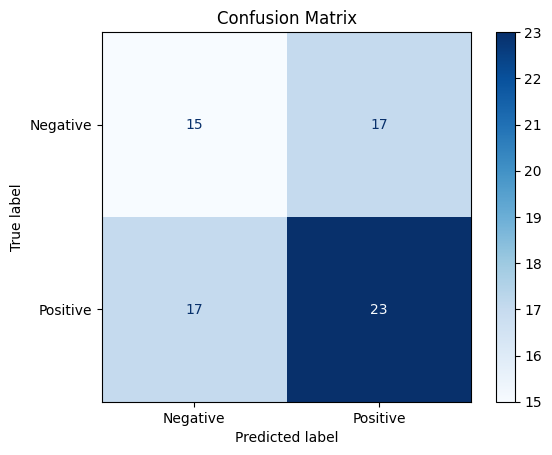

In [11]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Data summary stats

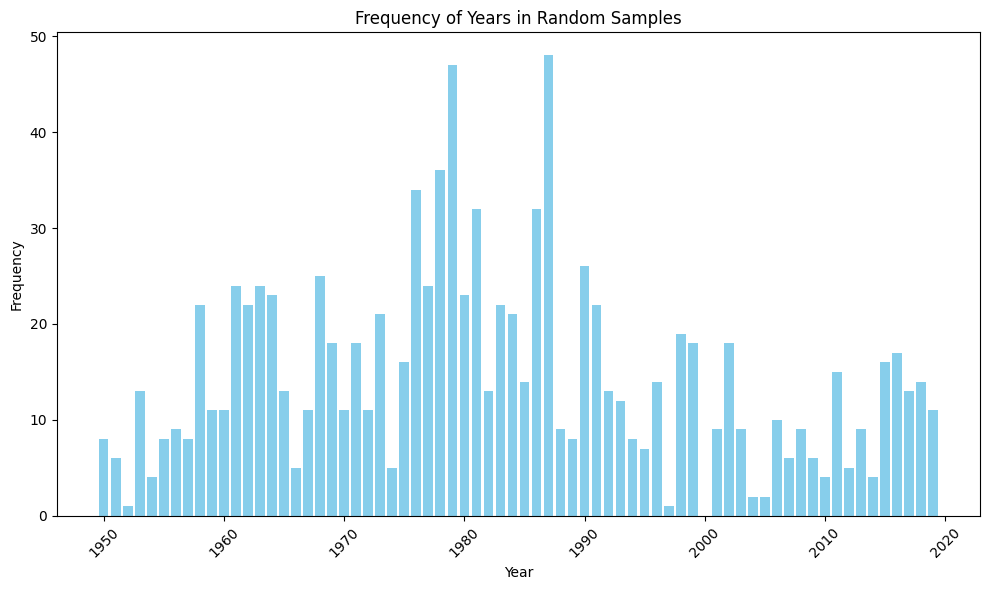

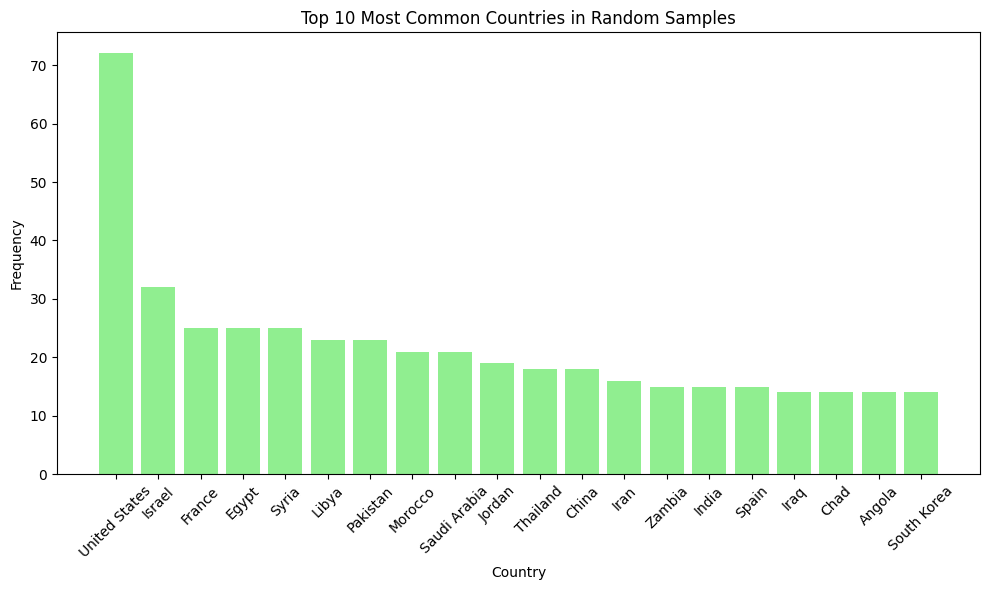

Total number of samples: 1030
Number of unique years: 69
Number of unique countries: 128


In [26]:
years = [sample[3] for sample in random_samples]
countries = [sample[2] for sample in random_samples]

year_counts = Counter(years)
country_counts = Counter(countries)

# Plot bar chart for years
plt.figure(figsize=(10, 6))
plt.bar(year_counts.keys(), year_counts.values(), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Years in Random Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot bar chart for countries
top_countries = country_counts.most_common(20)  # Top 10 most common countries
plt.figure(figsize=(10, 6))
plt.bar([country[0] for country in top_countries], [country[1] for country in top_countries], color='lightgreen')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Countries in Random Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Other summary statistics
total_samples = len(random_samples)
num_unique_years = len(year_counts)
num_unique_countries = len(country_counts)
print(f'Total number of samples: {total_samples}')
print(f'Number of unique years: {num_unique_years}')
print(f'Number of unique countries: {num_unique_countries}')